# Generalized revised AKPR model for multiple ligands and receptor types

Allowing $P$ receptor types, indexed $\rho \in \{1, 2, \ldots, P \}$, each with $q^\rho$ ligand types. Complicated but tractable. 

Receptor states are now $C^\rho_{n, l}$, with $\rho$ the receptor type, $n$ the activation state, $l$ the ligand type. The number of receptors of type $\rho$ bound to ligand type $l$ is $R_{b,l}^\rho$. 

## Generalizing the steady-state solutions

### Numbers of bound receptors
Solution for the numbers of bound receptors: not analytical anymore but reduces to a scalar equation for each receptor type $\rho$, an equation for the total number of unbound receptors, $F^\rho = R^\rho_{\mathrm{tot}} - \sum_s R^\rho_{b,s}$. This equation is – dropping the $\rho$ superscript, as there is one separate such equation for each type –

$$ 0 = -(R_{\mathrm{tot}} - F) \prod_{l=1}^q \left(F + \frac{1}{\kappa \tau_l}\right)
    + \sum_s \left[ F L_s \prod_{l=1, l \neq s}^q \left(F + \frac{1}{\kappa \tau_l}\right) \right] $$

Once the solution $F$ is known, the number of receptors bound to ligand $l$ is

$$ R_{b,l} = \frac{F L_l}{F + \frac{1}{\kappa \tau_l}} $$

### Numbers of receptors in proofreading states
The steady-state solutions for the $C^{\rho}_{n, l}$ are given by

$$ C^{\rho}_{n,l} = \left\{ 
    \begin{array}{ll}
        (\Phi^\rho_l)^n (1-\Phi^\rho_l) R^\rho_{b,l}    &  n < N^\rho - f^\rho  \\
        (\Phi^\rho_l)^{N^\rho - f^{\rho}} (\Phi_{\vec{I},l}^\rho)^{n - N^\rho + f^{\rho}} (1-\Phi_{\vec{I},l}^\rho) R^\rho_{b,l}    & N^\rho - f^{\rho} \leq n < N^\rho   \\
        (\Phi^\rho_l)^{N^\rho - f^{\rho}} (\Phi_{\vec{I},l}^\rho)^{f^{\rho}} R^\rho_{b,l}    & n = N^\rho
    \end{array}
    \right. $$

where $\Phi^{\rho}_l = \frac{\varphi^\rho \tau^\rho_l}{\varphi^\rho \tau^\rho_l + 1}$ and $\Phi_{\vec{I},l}^{\rho} = \frac{\psi^\rho(\vec{I}) \tau^\rho_l}{\psi^\rho(\vec{I}) \tau^\rho_l + 1}$. Notice that $1 - \Phi = \frac{1}{\varphi \tau + 1}$. 

If all $m^{\rho} < N^\rho - f^\rho$, these solutions are explicit since we can determine the $I^{\rho}$ (see equation below). Otherwise, they are implicit and require some solving for the $\vec{I}$ first. 

The rates $\psi^{\rho}(\vec{I})$ are not different from the "1 ligand per receptor type" case, since they do not directly imply the ligand types, only the receptor types for $\vec{I}$. 

### Inhibitory module: explicit and implicit solutions

For $P$ receptor types, the variables for which we need to close implicit equations are the $I^\rho$. Say there are $p_i$ of them. They are given by

$$ I^{\rho} = I_{\mathrm{tot}} \frac{\sum_l C^\rho_{m^\rho,l} / C^\rho_{m,\mathrm{th}}}{1 + \sum_{\mu, l} C^\mu_{m^\mu,l} / C^\mu_{m,\mathrm{th}}} $$

But we can't directly solve for the implicitly-defined $I^{\rho}$ only. Indeed, while the system of equation has $p_i$ real independent variables, the equations for all $I^{\rho}$, implicit or not, contain $C^\mu_{m^\mu,l}$ for all receptor types, which rely on $\psi^\rho(\vec{I})$, which in turn contain the $I^\rho$ for explicit types, which we don't know yet. 

To get out of this unsolvable loop and eliminate degrees of freedom corresponding to explicit receptor types, we instead solve the set of equations for the sums of $C_{m,l}$s, which we label

$$ \sigma^\rho = \sum_l C^{\rho}_{m,l} $$

Contrary to the $I^{\rho}$, these $\sigma^\rho$ are directly derivable for explicit receptor types (i.e. those where $m < N-f$), so we really are left with $p_i$ unknowns, the $\sigma^\rho$ of implicit types. So we can solve for these missing $\sigma^\rho$s iteratively:
1. Compute once the $\sigma^\rho$ of explicit receptor types
2. Assume a value for the $\sigma^\rho$ implicit receptor types
3. Compute all $I^{\rho}$, implicit and explicit, from these known and assumed $\sigma$s
4. From these $I^{\rho}$, compute $C^\rho_{m,l}(\psi(\vec{I}))$ for the implicit receptor types
5. Update the estimate of $\sigma^\rho$ by summing the computed complexes: $\sigma^{\rho} = \sum_l C^\rho_{m,l}(\psi(\vec{I}(\sigma^\rho)))$.  

So, the system of equations to solve numerically for the missing $\sigma^\rho$ is

$$ 0 = \sigma^{\rho} - \sum_l C^{\rho}_{m,l}(\psi(\vec{I}(\sigma^{\rho}))) \quad \forall \rho \in \mathrm{implicit \,\, types} $$

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import root_scalar, root as rootsolve

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import json, h5py
import os

In [2]:
from models.tcr_car_akpr_model import (
    activation_function, steady_akpr_i_1ligand, psi_of_i_gamma, 
)
from utils.preprocess import (
    michaelis_menten, write_conc_uM
)
from mcmc.costs_tcr_car_antagonism import repackage_tcr_car_params

In [3]:
# Options to save plots and results to disk or not
do_save_plots = False
do_save_outputs = False

## Code the general solution

In [4]:
def solution_bound_receptors(lsp, tausp, kappap, Rsp):
    """ Solution for the number of bound receptors of one type, 
    when there are q^rho ligand types for that receptor. """
    # Solve for the total number of unbound receptors, Gamma
    # Assume that no tau is zero
    kaptaus = 1.0 / (kappap * tausp)
    n_ligs = len(tausp)
    # Equation for gamma: rhs = 0
    def rhs(gam):
        gam_facts = gam + kaptaus
        gam_prod = np.prod(gam_facts)
        fct = (gam - Rsp) * gam_prod
        fct += gam * np.sum(lsp * gam_prod / gam_facts)
        return fct
    
    # Find the root of this scalar polynomial high-degree equation
    guess = Rsp / 2.0  # between [0, Rsp] free receptors
    sol = root_scalar(rhs, method='brentq', bracket=(0.0, Rsp), x0=guess)
    # From gamma, compute the number of receptors bound to each type
    if sol.converged:
        gamma = sol.root
        rbs = gamma * lsp / (gamma + kaptaus)
    else:
        raise ValueError("Failed to solve for bound receptor numbers")
    
    return rbs

In [5]:
def implicit_cmtots_equation(cmtots, imp_idx, known_cmtots, ratesp, tausp, r_bounds, ITp, nparams):
    r""" Set of equations to solve for the implicit I types. More precisely, 
    we solve for the cmtots = $\sum_{l} C^\rho_{m, l}$ of receptor types \rho 
    which have implicit $I$ equations. 
    
    Args:
        cmtots (np.ndarray): tentative values of the C_{m,l} sums
            for implicit receptor types. 
        imp_idx (np.ndarray of bools): vector of length n_types, 
            True where receptor type has an implicit I equation. 
        known_cmtots (np.ndarrays): \sum_l C^\rho_{m,l} of explicit
            receptor types
        ratesp (list of np.ndarrays): as in the main function
        tausp (list of np.ndarrays): taus of all ligands and 
            receptor types
        r_bounds (list of np.ndarrays): numbers of bounds receptors
            of each type and ligand type
        ITp (float): total number of I molecules, I_tot
        nparams (list of np.ndarrays ints): Ns, ms, fs of
            all receptor types. 
    """
    phis, kappas, cmthreshs, ithreshs, ki, gamma_mat, psi0s  = ratesp
    n_types = len(phis)
    ns, ms, fs = nparams
    # Compute all I^rho
    denom_i = (np.sum(known_cmtots / cmthreshs[~imp_idx])
                + np.sum(cmtots / cmthreshs[imp_idx]) + 1.0)
    ivec = np.zeros(n_types)
    ivec[imp_idx] = cmtots / cmthreshs[imp_idx] / denom_i
    ivec[~imp_idx] = known_cmtots / cmthreshs[~imp_idx] / denom_i
    
    # Compute psi rates
    psi_vec = psi_of_i_gamma(ivec, ithreshs, ki, phis, gamma_mat, psi0s)
    
    # Compute C_{m,l}s and sum_l C_{m,l} for implicit receptor types
    cmtots_computed = []
    for r in range(n_types):
        if not imp_idx[r]: 
            continue
        elif ms[r] == ns[r] - fs[r]:
            phivec = phis[r] * tausp[r] / (phis[r] * tausp[r] + 1.0)
            cmvec_l = r_bounds[r] * phivec**ms[r] / (psi_vec[r] * tausp[r] + 1.0)
            cmtots_computed.append(np.sum(cmvec_l))
        elif ms[r] > ns[r] - fs[r] and ms[r] < ns[r]:
            phivec = phis[r] * tausp[r] / (phis[r] * tausp[r] + 1.0)
            phivec_psi = psi_vec[r] * tausp[r] / (psi_vec[r] * tausp[r] + 1.0)
            cmvec_l = r_bounds[r] * phivec**(ns[r] - fs[r]) * phivec_psi**(ms[r] - ns[r] + fs[r])
            cmvec_l *= (1.0 - phivec_psi)
            cmtots_computed.append(np.sum(cmvec_l))
        elif ms[r] == ns[r]:
            phivec = phis[r] * tausp[r] / (phis[r] * tausp[r] + 1.0)
            phivec_psi = psi_vec[r] * tausp[r] / (psi_vec[r] * tausp[r] + 1.0)
            cmvec_l = r_bounds[r] * phivec**(ns[r] - fs[r]) * phivec_psi**fs[r]
            cmtots_computed.append(np.sum(cmvec_l))
        else:
            raise ValueError("Receptor type {} reported implicit, but has m < N-f".format(r))
    if len(cmtots_computed) > 1:
        cmtots_computed = np.asarray(cmtots_computed)
    else:
        cmtots_computed = cmtots_computed[0]
    
    # Compare to the originally assumed cmtots: the equation to solve
    return cmtots - cmtots_computed

In [6]:
# Main functions solving the SHP-1 model with multiple receptor types.
def steady_akpr_i_generalized_types(ratesp, tausp, lsp, ri_tots, nparams):
    r"""Solving for the steady_state of the SHP-1 model with P
    different receptor types, each with q^r ligand types. 

    Args:
        ratesp (list of np.ndarrays): [phi_arr, kappa_arr, cmthresh, ithresh_arr,
            k_arr, gamma_mat, psi_arr] where x_arr is
            a 1d array of parameter x values for each receptor type.
            except cmthresh which is unique,
            and gammat is a KxK array for K receptor types,
            containing \gamma_{ij}, contribution of SHP-1 bound to receptor type j
            to the negative feedforward on receptor type i.
        tausp (list of 1d arrays of floats): binding times of the ligands
            of each type of receptor (each array in the list 
            is for a different receptor type). 
        lsp (np.ndarray of floats): total number of ligands of each type. 
            Structured as tausp: each array in the list for a receptor type. 
        ri_tots (list of 1 ndarray, 1 float):
            Rsp (np.ndarray of floats): total number of receptors of each type
            ITp (float): total number of SHP-1 molecules
        nparams (list of 3 np.ndarrays): Ns, ms, fs of all receptor types.

    Returns:
        complexes (np.ndarray): list of 2D arrays of complexes or I, ordered
            [[[C^1_{0,1}, C^1_{1,1}, ..., C^1_{N,1}],
              [C^1_{0,2}, C^1_{1,2}, ..., C^1_{N,2}]],
              
             [[C^2_{0,1}, C^2_{1,1}, ..., C^2_{N,1}],
              [C^2_{0,2}, C^2_{1,2}, ..., C^2_{N,2}]],
              ...
             [[C^P_{0,1}, C^P_{1,1}, ..., C^P_{N,1}],
              [C^P_{0,2}, C^P_{1,2}, ..., C^P_{N,2}]],
              [I^1, I^2, ..., I^P]
            ]
        So we can get C^r_{n,l} as complexes[r-1][l-1, n], 
        and I^r as complexes[-1][r-1]. 
    """
    # Exploit the vector-compatible form of the function solving for C_Ts
    phis, kappas, cmthreshs, ithreshs, ki, gamma_mat, psi0s  = ratesp
    Rsp, ITp = ri_tots
    n_types = len(Rsp)
    ns, ms, fs = nparams
    q_rs = [len(a) for a in tausp]  # Number of ligand types for each receptor type
    # C_n for each type, and lastly the I vector.
    complexes = []
    for r in range(n_types):
        n_rho = nparams[0][r]
        q_ligs = q_rs[r]
        complexes.append(np.zeros([q_ligs, n_rho+1]))
    complexes.append(np.zeros(n_types))

    # Special case: no input
    if sum([np.sum(a) for a in lsp]) == 0.0 or sum([np.sum(a) for a in tausp]) == 0.0:
        return complexes

    # Solve for R^rho_{b,l}: numbers of bound receptors
    r_bounds = []
    for r in range(n_types):
        rbs = solution_bound_receptors(lsp[r], tausp[r], kappas[r], Rsp[r])
        r_bounds.append(rbs)

    # Phi factors in steps prior to inhibitory module effect
    geofacts = [phis[r]*tausp[r] / (phis[r]*tausp[r] + 1.0)
                for r in range(n_types)]

    # Compute all Cns and Dns below N-f: apply same factor recursively
    for r in range(n_types):
        if ns[r] == fs[r]: continue  # No complex to compute
        # Otherwise, we can at least compute C_0
        # for all ligand types l at the same time
        complexes[r][:, 0] = r_bounds[r] * (1.0 - geofacts[r])
        for n in range(1, ns[r]-fs[r]):
            complexes[r][:, n] = complexes[r][:, n-1]*geofacts[r]

    # Now, compute the vector I and psi(I)
    # Check which I are implicit, if any
    implicit_types = np.asarray([ms[r] >= ns[r]-fs[r] for r in range(n_types)], dtype=bool)
    implicit_idx = np.nonzero(implicit_types)[0]
    explicit_idx = np.nonzero(~implicit_types)[0]
    
    # Case where all m < N - f: we already have all C_m
    if len(implicit_idx) == 0:
        cmnorm_vecs = [complexes[r][:, ms[r]]/cmthreshs[r] for r in range(n_types)]
        sum_l_cm = np.asarray([np.sum(cm) for cm in cmnorm_vecs])
        sum_lr_cm = np.sum(sum_l_cm)
        ivec = ITp * sum_l_cm / (1.0 + sum_lr_cm)
    
    # At least one implicit: solve for the implicit \sum_l C_{m,l}
    elif len(implicit_idx) >= 1:
        # f, args=(), method=None, bracket=None, fprime=None, fprime2=None, x0=None, 
        # x1=None, xtol=None, rtol=None, maxiter=None, options=None
        # Compute known sum_l C_{m,l} for explicit types
        known_cmtots = np.asarray([np.sum(complexes[r][:, ms[r]]) for r in explicit_idx])
        solve_args = (implicit_types, known_cmtots, ratesp, tausp, r_bounds, ITp, nparams)
        if len(implicit_idx) == 1:
            sol = root_scalar(implicit_cmtots_equation, args=solve_args, method="brentq", 
                         bracket=[0.0, Rsp[implicit_idx]], x0=Rsp[implicit_idx]*0.5)
            if sol.converged:
                unknown_cmtots = sol.root
            else:
                raise ValueError("Could not converge to sum of C_{m,l} solution")
        else:
            # fun, x0, args=(), method='hybr', jac=None, tol=None, callback=None, options=None
            sol = rootsolve(implicit_cmtots_equation, x0=0.5*Rsp[implicit_idx]/n_types, 
                           args=solve_args)
            if sol.success:
                unknown_cmtots = sol.x
                
        all_cmtots = np.zeros(n_types)
        all_cmtots[implicit_idx] = unknown_cmtots / cmthreshs[implicit_idx]
        all_cmtots[explicit_idx] = known_cmtots / cmthreshs[explicit_idx]
        
        # From the cmtots, compute vector of I
        ivec = ITp * all_cmtots / (1.0 + np.sum(all_cmtots))

    if np.sum(ivec) > ITp:
        raise ValueError("Found a I solution going over the max number of I")

    # Compute the psi(S) vector with the solution ivec.
    psis = psi_of_i_gamma(ivec, ithreshs, ki, phis, gamma_mat, psi0s)

    # Finally, compute C_{N-f}, ..., C_N for each receptor type
    for r in range(n_types):
        n = ns[r] - fs[r]
        phi_psis = psis[r] * tausp[r] / (psis[r] * tausp[r] + 1.0)
        if n > 0:
            complexes[r][:, n] = complexes[r][:, n-1] * phis[r]*tausp[r] * (1.0 - phi_psis)
        else:
            complexes[r][:, n] = r_bounds[r] * (1.0 - phi_psis)
        for n in range(ns[r] - fs[r] + 1, ns[r]):
            complexes[r][n] = complexes[r][:, n-1] * phi_psis
        complexes[r][:, ns[r]] = complexes[r][:, ns[r]-1] * psis[r]*tausp[r]

    # Check consistency
    if len(implicit_idx) == 1:
        cmtots_recomputed = np.asarray([np.sum(complexes[r][:, ms[r]]) / cmthreshs[r] 
                                       for r in range(n_types)])
        if np.all(np.abs(cmtots_recomputed - all_cmtots)) > 1e-3:
            print("Difference in implicit solution and final calculated C_m/C_{m,th}:",
                    all_cmtots, cmtots_recomputed)
    # Add the vector of S values to the returned variables
    complexes[-1] = ivec

    # Return
    return complexes

In [7]:
def compute_model_output_curve(tau_tcr, l_tcr, cd19, kw_params, highlights=None, 
                               baseline=0.0, scale_down_zt=1.0):
    """ For one given CD19 condition, typically one L_TCR, and an axis of tau_T values. """
    # Prepare L, tau ranges
    if highlights is not None:
        tau_tcr2 = np.unique(np.sort(np.concatenate([tau_tcr, highlights])))
    else:
        tau_tcr2 = tau_tcr
    l_tcr2 = np.asarray(l_tcr)
    # Tonic signaling of CAR in the absence of CD19
    #if cd19[1] == 0.0:
    #    cd19 = [cd19[0]*0.01, 1e4]
    
    # Extract parameters
    p = kw_params
    
    # Agonist alone output
    ag_alone = steady_akpr_i_1ligand(p["car_rates"], *cd19, p["car_ri"], p["car_nmf"])[p["car_nmf"][0]]
    ag_alone = activation_function(ag_alone, p["car_thresh"]) + baseline
    
    # Tonic TCR signaling for CD19 alone?
    #taus = np.asarray([1.0, cd19[0]])
    #lvec = np.asarray([1e4, 0.5])
    #ag_alone = steady_akpr_i_receptor_types(p["all_rates"], taus, lvec, p["ritot_vec"], p["nmf_both"])
    #ag_alone = (activation_function(ag_alone[0][p["tcr_nmf"][0]], p["tcr_thresh"]) 
    #            + activation_function(ag_alone[1][p["car_nmf"][0]], p["car_thresh"]) + baseline)

    model_columns = pd.Index([r"$T_{}$".format(n) for n in range(p["tcr_nmf"][0]+1)] 
                       + [r"$C_{}$".format(n) for n in range(p["car_nmf"][0]+1)]
                       + [r"$I_T$", r"$I_C$", r"$Z_T$", r"$Z_C$", "Ratio"], name="Variable")
    model_index = pd.MultiIndex.from_product([l_tcr2, tau_tcr2], names=[r"$L_T$", r"$\tau_T$"])
    df_m = pd.DataFrame(np.zeros([len(model_index), len(model_columns)]), 
                           columns=model_columns, index=model_index)

    for l_t, tau_t in model_index:
        taus = np.asarray([[tau_t], [cd19[0]]])
        lvec = np.asarray([[l_t], [cd19[1]]])
        complexes_mix = steady_akpr_i_generalized_types(p["all_rates"], 
                                taus, lvec, p["ritot_vec"], p["nmf_both"])
        df_m.loc[(l_t, tau_t), r"$T_0$":r"$T_{}$".format(p["tcr_nmf"][0])] = complexes_mix[0][0]
        df_m.loc[(l_t, tau_t), r"$C_0$":r"$C_{}$".format(p["car_nmf"][0])] = complexes_mix[1][0]
        df_m.loc[(l_t, tau_t), r"$I_T$":r"$I_C$"] = complexes_mix[2]
        # Normalize outputs to compare CAR and TCR properly, accounting for
        # their very different signaling potencies.
        
        df_m.loc[(l_t, tau_t), r"$Z_T$"] = activation_function(complexes_mix[0][0, -1], p["tcr_thresh"])
        # Somehow the TCR output doesn't contribute as much; scale it down?
        df_m.loc[(l_t, tau_t), r"$Z_T$"] *= scale_down_zt
        df_m.loc[(l_t, tau_t), r"$Z_C$"] = activation_function(complexes_mix[1][0, -1], p["car_thresh"])
        df_m.loc[(l_t, tau_t), "Ratio"] = (df_m.loc[(l_t, tau_t), r"$Z_T$":r"$Z_C$"].sum() + baseline) / ag_alone
    
    return df_m

In [8]:
def compute_model_output_tcr_mix(taus_tcr, ls_tcr, cd19, kw_params,
                               baseline=0.0, scale_down_zt=1.0):
    """ For one given CD19 condition and a mixture of two TCR antigens. 
    Pass lists of L_1, L_2, tau_1, tau_2 values desired, and all combinations
    of these values will be computed, and the values used as DataFrame index. """
    # Extract parameters
    p = kw_params
    
    # The "CAR only" output used at the denominator is 
    # without any TCR antagonist. CAR antigen alone. 
    # Agonist alone output
    ag_alone = steady_akpr_i_1ligand(p["car_rates"], *cd19, p["car_ri"], p["car_nmf"])[p["car_nmf"][0]]
    ag_alone = activation_function(ag_alone, p["car_thresh"]) + baseline
    
    # Prepare product multiindex
    n_tcr_ligs = len(taus_tcr)
    assert n_tcr_ligs == len(ls_tcr)
    tcr_labels = [r"$L^T_{}$".format(l) for l in range(n_tcr_ligs)]
    tcr_labels += [r"$\tau^T_{}$".format(l) for l in range(n_tcr_ligs)]
    model_index = pd.MultiIndex.from_product([*ls_tcr, *taus_tcr], names=tcr_labels)
    
    # DataFrame columns: MultiIndex indexed (rho, l, n)
    all_tuples = []
    for n in range(p["tcr_nmf"][0]+1):
        for l in range(n_tcr_ligs):
            all_tuples.append(("TCR", l, n))
    for n in range(p["car_nmf"][0]+1):
        all_tuples.append(("CAR", 0, n))
    for r in range(2):
        all_tuples.append(("I", 0, r))
    for lbl in [r"$Z^T$", r"$Z^C$", "Ratio"]:
        all_tuples.append((lbl, 0, 0))
    model_columns = pd.MultiIndex.from_tuples(all_tuples, names=["Receptor type", "Ligand type", "Step"])
        

    df_m = pd.DataFrame(np.zeros([len(model_index), len(model_columns)]), 
                           columns=model_columns, index=model_index)
    df_m = df_m.sort_index(axis=0).sort_index(axis=1)
    
    for idx in model_index:
        l_ts = np.asarray(idx[:n_tcr_ligs])
        tau_ts = np.asarray(idx[n_tcr_ligs:])
        taus = [tau_ts, np.asarray([cd19[0]])]
        lvec = [l_ts, np.asarray([cd19[1]])]
        complexes_mix = steady_akpr_i_generalized_types(p["all_rates"], 
                                taus, lvec, p["ritot_vec"], p["nmf_both"])
        for l in range(n_tcr_ligs):  # TCR
            df_m.loc[idx, ("TCR", l)] = complexes_mix[0][l]
        df_m.loc[idx, ("CAR", 0)] = complexes_mix[1][0]
        df_m.loc[idx, ("I", 0)] = complexes_mix[-1]
        
        # Normalize outputs to compare CAR and TCR properly, accounting for
        # their very different signaling potencies.
        df_m.loc[idx, r"$Z^T$"] = scale_down_zt * activation_function(
            np.sum(complexes_mix[0][:, -1]), p["tcr_thresh"]
        )
        # Somehow the TCR output doesn't contribute as much; scale it down?
        df_m.loc[idx, r"$Z^C$"] = activation_function(complexes_mix[1][0, -1], p["car_thresh"])
        df_m.loc[idx, "Ratio"] = (df_m.loc[idx, [r"$Z^T$",r"$Z^C$"]].sum() 
                                           + baseline) / ag_alone
    return df_m

## Test the general model on known cases

In [9]:
with open(os.path.join("data", "pep_tau_map_ot1.json"), "r") as handle:
    pep_tau_map = json.load(handle)

In [10]:
# Import TCR/CAR parameters
# Load best parameter fit for (1, 2, 1)
fit_conc = ["1uM", "1nM"]
analysis_res_fname = "mcmc_analysis_tcr_car_both_conc.json"
with open(os.path.join("results", "mcmc", analysis_res_fname), "r") as jfile:
    all_results_dicts = json.load(jfile)
    del jfile

# Go back to linear-scale parameters
chosen_kmf = (1, 2, 1)
pvec_best = np.asarray(all_results_dicts.get(str(chosen_kmf)).get("param_estimates").get("MAP best"))

# Load constant parameter values
samples_fname = samples_fname = "mcmc_results_tcr_car_both_conc.h5"
with h5py.File(os.path.join("results", "mcmc", samples_fname), "r") as rfile:
    data_group = rfile.get("data")
    fit_param_names = list(rfile.get("samples").attrs.get("param_names"))
    l_conc_mm_params = data_group.get("l_conc_mm_params")[()]
    cost_args_loaded = [data_group.get(a)[()]
                        for a in data_group.attrs.get("cost_args_names")]
    del data_group, rfile

In [11]:
### Rearrange loaded parameters in the correct format 
other_rates, ritot, nmf_fixed, cd19_tau_l = cost_args_loaded
res = repackage_tcr_car_params(pvec_best, chosen_kmf, *cost_args_loaded[:3])
(
all_rates, tcr_rates, car_rates, ritot_vec, tcr_ri, car_ri,
nmf_both, tcr_nmf, car_nmf, threshold_taus
) = res
# Compute thresholds
tcr_thresh = steady_akpr_i_1ligand(tcr_rates, threshold_taus[0],
        10*tcr_ri[0], tcr_ri, tcr_nmf, large_l=True)[tcr_nmf[0]]
car_thresh = steady_akpr_i_1ligand(car_rates, threshold_taus[1],
        10*car_ri[0], car_ri, car_nmf, large_l=True)[car_nmf[0]]

In [12]:
# Nice big parameter dictionary
param_dict = {
    "car_rates": car_rates, 
    "car_ri": car_ri, 
    "car_nmf": car_nmf, 
    "all_rates": all_rates, 
    "tcr_nmf": tcr_nmf, 
    "ritot_vec": ritot_vec, 
    "nmf_both": nmf_both, 
    "tcr_thresh": tcr_thresh, # TCR threshold seems higher for PLCgamma? 
    "car_thresh": car_thresh
}

# Compute model output for E2aPBX CD19
tau_tcr_range = np.linspace(0.001, 10.0, 101)
conc_t_range = np.logspace(-3, 0, 2)
conc_t_labels = list(map(write_conc_uM, conc_t_range))
l_tcr_range = michaelis_menten(conc_t_range, *l_conc_mm_params)

# Loop over tumor cell lines, concat DataFrames after
df_model = compute_model_output_curve(tau_tcr_range, l_tcr_range, 
                cd19_tau_l, param_dict, baseline=0.0)

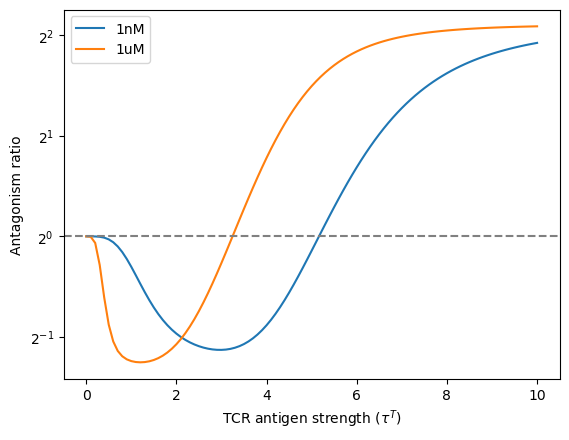

In [13]:
fig, ax = plt.subplots()
for i, l_t in enumerate(l_tcr_range):
    ax.plot(tau_tcr_range, df_model.loc[(l_t, tau_tcr_range), "Ratio"], 
            label=conc_t_labels[i])
ax.set(xlabel=r"TCR antigen strength ($\tau^T$)", ylabel="Antagonism ratio")
ax.set_yscale('log', base=2)
ax.axhline(1.0, ls="--", color="grey")
ax.legend()
plt.show()
plt.close()

## Test HER2 CAR antagonism by HHAT-WT + HHAT-p8F mixture of TCR antigens

In [14]:
# Import surface molecule numbers first
molec_counts_filename = "data/surface_counts/surface_molecule_summary_stats.h5"
df_her = pd.read_hdf(molec_counts_filename, key="surface_numbers_stats")
# The experiment only used BEAS2B_GL and PC9_GL
df_her = df_her.loc[df_her.index.isin(["BEAS2B", "PC9"], level="Cell")]
df_her = (df_her.rename({"BEAS2B":"BEAS2B_GL", "PC9":"PC9_GL"}, level="Cell", axis=0)
            .rename({"MHC":"HLA_A2"}, level="Marker", axis=0))

# Data on L_T, L_C for both APC lines
size_factor_her = 1.0  # Unsure of the size, don't correct because qualitative anyways
mtc = "Geometric mean"
hla_levels = {
    "BEAS2B-GL": df_her.loc[("BEAS2B_GL", "HLA_A2"), mtc] / size_factor_her,
    "PC9-GL": df_her.loc[("PC9_GL", "HLA_A2"), mtc] / size_factor_her
}

her2_levels = {
    "BEAS2B-GL": df_her.loc[("BEAS2B_GL", "Her2"), mtc] / size_factor_her,
    "PC9-GL": df_her.loc[("PC9_GL", "Her2"), mtc] / size_factor_her
}

# High affinity ligand for the CAR, assume it is just like CD19.  
her2_tau = cd19_tau_l[0]

# Based on CD25 dose response EC50 conversion, tau for the two peptides
with open("data/pep_tau_map_others.json", "r") as h:
    other_taus = json.load(h)
hhat_pep_taus = {
    "HHAT-WT": other_taus.get("HHAT-WT"), 
    "HHAT-p8F": other_taus.get("HHAT-p8F")
}

### Model predictions for the experimental conditions

In [15]:
apc_mix = "PC9-GL"
tau_antag_tcr_range = np.asarray([hhat_pep_taus["HHAT-WT"]])
tau_ag_tcr_range = np.asarray([hhat_pep_taus["HHAT-p8F"]])
pulses_antag = [0.0, 5e0]
pulses_ag = [0.0, 5e0]
l_antag_tcr_range = np.asarray([michaelis_menten(pu, hla_levels[apc_mix], l_conc_mm_params[1])
                                for pu in pulses_antag])
l_ag_tcr_range = np.asarray([michaelis_menten(pu, hla_levels[apc_mix], l_conc_mm_params[1])
                                for pu in pulses_ag])
her2_tau_l = [her2_tau, her2_levels["PC9-GL"]]
tau_both_tcr = [tau_antag_tcr_range, tau_ag_tcr_range]
l_both_tcr = [l_antag_tcr_range, l_ag_tcr_range]
df_model_aebs = compute_model_output_tcr_mix(tau_both_tcr, l_both_tcr, her2_tau_l, param_dict,
                               baseline=0.0, scale_down_zt=1.0)

In [16]:
df_model_aebs

Receptor type                                         $Z^C$     $Z^T$  \
Ligand type                                               0         0   
Step                                                      0         0   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$                       
0.000000      0.000000      0.988179   4.204923    0.082805  0.000000   
              722105.874893 0.988179   4.204923    0.011368  0.529014   
722105.874893 0.000000      0.988179   4.204923    0.011520  0.000817   
              722105.874893 0.988179   4.204923    0.011368  0.483091   

Receptor type                                               CAR               \
Ligand type                                                   0                
Step                                                          0            1   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$                              
0.000000      0.000000      0.988179   4.204923    25623.686589  5903.308766   
              722105.874893 0.988179   4.204923    25623.686589  5903.308766   
722105.874893 0.000000      0.988179   4.204923    25623.686589  5903.308766   
              722105.874893 0.988179   4.204923    25623.686589  5903.308766   

Receptor type                                                               \
Ligand type                                                                  
Step                                                         2           3   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$                            
0.000000      0.000000      0.988179   4.204923    1574.878860  192.280709   
              722105.874893 0.988179   4.204923    1698.538211   68.621358   
722105.874893 0.000000      0.988179   4.204923    1698.076079   69.083490   
              722105.874893 0.988179   4.204923    1698.536619   68.622951   

Receptor type                                             I            \
Ligand type                                               0             
Step                                                      0         1   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$                       
0.000000      0.000000      0.988179   4.204923    0.000000  0.011360   
              722105.874893 0.988179   4.204923    0.367370  0.007744   
722105.874893 0.000000      0.988179   4.204923    0.007623  0.012144   
              722105.874893 0.988179   4.204923    0.316150  0.008371   

Receptor type                                         Ratio            TCR  \
Ligand type                                               0              0   
Step                                                      0              0   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$                            
0.000000      0.000000      0.988179   4.204923    1.000000       0.000000   
              722105.874893 0.988179   4.204923    6.525978       0.000000   
722105.874893 0.000000      0.988179   4.204923    0.148986  107107.407494   
              722105.874893 0.988179   4.204923    5.971393   22520.565352   

Receptor type                                      ...                       \
Ligand type                                        ...                        
Step                                               ...          4         5   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$  ...                        
0.000000      0.000000      0.988179   4.204923    ...   0.000000  0.000000   
              722105.874893 0.988179   4.204923    ...   0.000000  0.000000   
722105.874893 0.000000      0.988179   4.204923    ...  13.423066  1.586949   
              722105.874893 0.988179   4.204923    ...   2.822354  0.333946   

Receptor type                                                              \
Ligand type                                                             1   
Step                                                      6             0   
$L^T_0$       $L^T_1$       $\tau^T_0$ $\tau^T_1$                          

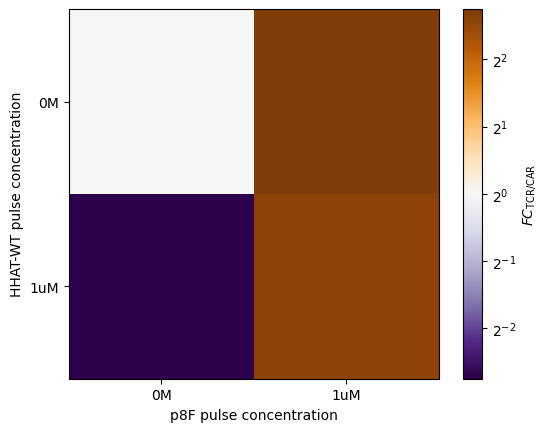

In [17]:
# Plot results: heatmap of antagonism/enhancement
log2_fcs = np.log2(df_model_aebs.loc[:, "Ratio"].droplevel([r"$\tau^T_0$", r"$\tau^T_1$"]))
log2_fcs = log2_fcs.unstack(r"$L^T_1$")  # Agonist is in columns
max_ampli = np.abs(log2_fcs.values).max()
normalizer = mpl.colors.Normalize(vmin=-max_ampli, vmax=max_ampli)

fig, ax = plt.subplots()
im = ax.imshow(log2_fcs, norm=normalizer, cmap="PuOr_r")
ax.set(xlabel="p8F pulse concentration", ylabel="HHAT-WT pulse concentration")
ax.set_xticks(np.arange(log2_fcs.shape[1]))
ax.set_xticklabels([write_conc_uM(a) for a in pulses_ag])
ax.set_yticks(np.arange(log2_fcs.shape[0]))
ax.set_yticklabels([write_conc_uM(a) for a in pulses_antag])
cbar = fig.colorbar(im, label=r"$FC_{\mathrm{TCR/CAR}}$")
cbar_ticks = np.arange(-int(np.floor(max_ampli)), int(np.floor(max_ampli))+1, 1)
cbar.ax.set_yticks(cbar_ticks)
cbar.ax.set_yticklabels(["$2^{" + str(int(a)) + r"}$" for a in cbar_ticks])
if do_save_plots:
    fig.savefig("figures/extra_predictions/tcr-car_antagonism_predictions_hhat_wt_p8f_her2car_mix_exp_pulse.pdf", 
           transparent=True, bbox_inches="tight")
plt.show()
plt.close()

In [18]:
# Reformat dataframe to export for Sooraj
df_model_aebs_nice = df_model_aebs[("Ratio", 0, 0)]
df_model_aebs_nice.index = df_model_aebs_nice.index.rename(
    {r"$L^T_0$":"Ag_1_density_M", r"$L^T_1$":"Ag_2_density_M", 
    r"$\tau^T_0$":"Ag_1", r"$\tau^T_1$":"Ag_2"})
df_model_aebs_nice = df_model_aebs_nice.rename({a:k for k, a in hhat_pep_taus.items()}, level="Ag_1")
df_model_aebs_nice = df_model_aebs_nice.rename({a:k for k, a in hhat_pep_taus.items()}, level="Ag_2")
df_model_aebs_nice = df_model_aebs_nice.rename(
    {l_ag_tcr_range[i]:pulses_ag[i]*1e-6 for i in range(2)}, level="Ag_1_density_M")
df_model_aebs_nice = df_model_aebs_nice.rename(
    {l_antag_tcr_range[i]:pulses_antag[i]*1e-6 for i in range(2)}, level="Ag_2_density_M")
df_model_aebs_nice.name = "FC_TCR-CAR"
df_model_aebs_nice.index = df_model_aebs_nice.index.reorder_levels([
    "Ag_1", "Ag_2", "Ag_1_density_M", "Ag_2_density_M"
])
df_model_aebs_nice

Ag_1     Ag_2      Ag_1_density_M  Ag_2_density_M
HHAT-WT  HHAT-p8F  0.000000        0.000000          1.000000
                                   0.000005          6.525978
                   0.000005        0.000000          0.148986
                                   0.000005          5.971393
Name: FC_TCR-CAR, dtype: float64

In [19]:
if do_save_outputs:
    df_model_aebs_nice.to_hdf("results/for_plots/tcr_antigen_mixture_car_antagonism_model.h5", key="exp_pulse")

### Model predictions for a whole range of antigen densities

In [20]:
apc_mix = "PC9-GL"
tau_antag_tcr_range = np.asarray([hhat_pep_taus["HHAT-WT"]])
tau_ag_tcr_range = np.asarray([hhat_pep_taus["HHAT-p8F"]])
pulses_antag2 = np.logspace(-5, 0, 100)  # 10 pM to 1 uM, in uM
pulses_ag2 = np.logspace(-5, 0, 100)
l_antag_tcr_range2 = michaelis_menten(pulses_antag2, hla_levels[apc_mix], l_conc_mm_params[1])
l_ag_tcr_range2 = michaelis_menten(pulses_ag2, hla_levels[apc_mix], l_conc_mm_params[1])
her2_tau_l = [her2_tau, her2_levels["PC9-GL"]]
tau_both_tcr = [tau_antag_tcr_range, tau_ag_tcr_range]
l_both_tcr = [l_antag_tcr_range2, l_ag_tcr_range2]
df_model_aebs2 = compute_model_output_tcr_mix(tau_both_tcr, l_both_tcr, her2_tau_l, param_dict,
                               baseline=0.0, scale_down_zt=1.0)

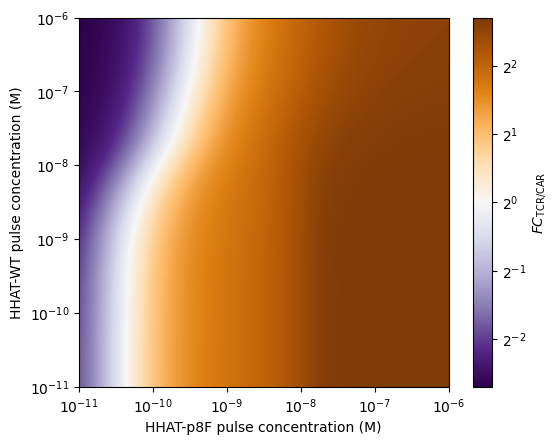

In [21]:
# Plot results: heatmap of antagonism/enhancement
log2_fcs = np.log2(df_model_aebs2.loc[:, "Ratio"].droplevel([r"$\tau^T_0$", r"$\tau^T_1$"]))
log2_fcs = log2_fcs.unstack(r"$L^T_1$")  # Agonist is in columns
max_ampli = np.abs(log2_fcs.values).max()
normalizer = mpl.colors.Normalize(vmin=-max_ampli, vmax=max_ampli)

fig, ax = plt.subplots()
im = ax.imshow(log2_fcs, norm=normalizer, cmap="PuOr_r", origin="lower", interpolation="gaussian", 
              extent=(-11, -6, -11, -6))
ax.set(xlabel=r"HHAT-p8F pulse concentration (M)", ylabel=r"HHAT-WT pulse concentration (M)")
ax.set_xticks(np.arange(-11, -5, 1))
ax.set_xticklabels([r"$10^{" + str(a) + r"}$" for a in ax.get_xticks()])
ax.set_yticks(np.arange(-11, -5, 1))
ax.set_yticklabels([r"$10^{" + str(a) + r"}$" for a in ax.get_yticks()])
                    
cbar = fig.colorbar(im, label=r"$FC_{\mathrm{TCR/CAR}}$")
cbar_ticks = np.arange(-int(np.floor(max_ampli)), int(np.floor(max_ampli))+1, 1)
cbar.ax.set_yticks(cbar_ticks)
cbar.ax.set_yticklabels(["$2^{" + str(int(a)) + r"}$" for a in cbar_ticks])
if do_save_plots:
    fig.savefig("figures/extra_predictions/tcr-car_antagonism_predictions_hhat_wt_p8f_her2car_mix_range.pdf", 
           transparent=True, bbox_inches="tight")
plt.show()
plt.close()

In [22]:
# Reformat dataframe to export for further plotting
df_model_aebs2_nice = df_model_aebs2[("Ratio", 0, 0)]
df_model_aebs2_nice.index = df_model_aebs2_nice.index.rename(
    {r"$L^T_0$":"Ag_1_density_M", r"$L^T_1$":"Ag_2_density_M", 
    r"$\tau^T_0$":"Ag_1", r"$\tau^T_1$":"Ag_2"})
df_model_aebs2_nice = df_model_aebs2_nice.rename({a:k for k, a in hhat_pep_taus.items()}, level="Ag_1")
df_model_aebs2_nice = df_model_aebs2_nice.rename({a:k for k, a in hhat_pep_taus.items()}, level="Ag_2")
df_model_aebs2_nice = df_model_aebs2_nice.rename(
    {l_ag_tcr_range2[i]:pulses_ag2[i]*1e-6 for i in range(2)}, level="Ag_1_density_M")
df_model_aebs2_nice = df_model_aebs2_nice.rename(
    {l_antag_tcr_range2[i]:pulses_antag2[i]*1e-6 for i in range(2)}, level="Ag_2_density_M")
df_model_aebs2_nice.name = "FC_TCR-CAR"
df_model_aebs2_nice.index = df_model_aebs2_nice.index.reorder_levels([
    "Ag_1", "Ag_2", "Ag_1_density_M", "Ag_2_density_M"
])
display(df_model_aebs2_nice)

if do_save_outputs:
    df_model_aebs2_nice.to_hdf("results/for_plots/tcr_antigen_mixture_car_antagonism_model.h5", key="range")

Ag_1     Ag_2      Ag_1_density_M  Ag_2_density_M
HHAT-WT  HHAT-p8F  1.000000e-11    1.000000e-11      0.299008
                                   1.123324e-11      0.319331
                                   8.591717e+01      0.344630
                                   9.651144e+01      0.375442
                                   1.084119e+02      0.412311
                                                       ...   
                   6.656372e+05    6.292087e+05      5.936490
                                   6.395388e+05      5.945269
                                   6.490244e+05      5.953113
                                   6.577085e+05      5.960118
                                   6.656372e+05      5.966371
Name: FC_TCR-CAR, Length: 10000, dtype: float64